# Mountain Project Web Scraping

In [1]:
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
from re import match
import time, os
from datetime import datetime
import pickle

In [2]:
# setup webdriver
chromedriver = "/Applications/chromedriver" 
os.environ["webdriver.chrome.driver"] = chromedriver

In [3]:
# Import the list of url links
open_file = open("routes_links.pkl", "rb")
links = pickle.load(open_file)
open_file.close()

### Scrape Each Route

In [77]:
# Empty list to store dictionaries of results
results = []

In [12]:
# open driver
driver = webdriver.Chrome(chromedriver)

# Loop through result links
for link in links:
    driver.get(link)
    time.sleep(2)
    
    soup = bs(driver.page_source, 'html.parser')
    
    # Dictionary for individual result
    result = {}
    
    # Get name
    try:
        result['name'] = soup.find('h1').text.strip()
    except:
        pass
    
    # Get location
    try:
        route_info = soup.find('div', id='route-page')
        loc_info = route_info.find('div', 
                                   class_='mb-half small text-warm')
        result['location'] = [link.text for link in loc_info.find_all('a')]
        result['park'] = result['location'][-2]
        result['wall'] = result['location'][-1]
    except:
        pass
    
    # Get grade rating
    try:
        grade = soup.find('span', class_='rateYDS').text.split(' ')[0]
        a = '1234567890.abcd'
        grade = ''.join([i for i in grade if i in a])
      
        grade_dict = {'5.0':0,'5.1':1,'5.2':2,'5.3':3,'5.4':4,'5.5':5,
                      '5.6':6,'5.7':7,'5.8':8,'5.9':9,'5.10a':10,
                      '5.10b':11,'5.10c':12,'5.10d':13,'5.11a':14,'5.11b':15,
                      '5.11c':16,'5.11d':17,'5.12a':18,'5.12b':19,'5.12c':20,
                      '5.12d':21,'5.13a':22,'5.13b':23,'5.13c':24,'5.13d':25,
                      '5.14a':26,'5.14b':27,'5.14c':28,'5.14d':29,'5.15a':30,
                      '5.15b':31,'5.15c':32,'5.15d':33}
        result['grade_score'] = [val for key,val in grade_dict.items() if key==grade][0]
    except:
        pass
    
    # Get details - style, length, pitches
    try:
        details = soup.find('table', class_='description-details')
        
        # Extract text
        details_type = (details.find(text='Type:')
                        .findNext().text.lower().strip().split(','))
        
        # Style
        for item in details_type:
            if details_type[0] == 'trad':
                result['style'] = 'trad'
            elif details_type[0] == 'sport':
                result['style'] = 'sport'
            elif details_type[0] == 'tr':
                result['style'] = 'tr'
        
        # Length 
        result['route_length'] = (list(filter(lambda v: match(r'^\s\d+\sft.*', v), 
                                              details_type))[0].strip().split(' ')[0])
    except:
        pass
    
    # was getting error, hopefully just because pitches not listed, default 1
    try:
        # Pitches
        result['num_pitches'] = (list(filter(lambda v: match(r'^.*\d+\spitches$', v), 
                                             details_type))[0].strip().split(' ')[0])
    except:
        result['num_pitches'] = 1
    
    # Get user-ratings
    try:
        stars_info = soup.find('a', class_='show-tooltip').text.strip().split(' ')
        result['num_ratings'] = int(stars_info[3].replace(',', ''))
        result['rating'] = float(stars_info[1])
    except:
        pass
    
    # Shared by date 
    try:
        shared_text = (details.find(text='Shared By:')
                       .findNext().text.strip().split(' '))
        result['share_date'] = [int(s) for s in shared_text if s.strip().isdigit()][0]
    except:
        pass
    
    # Average page-views
    try:
        views_text = (details.find('td', class_='pr-half text-nowrap')
                      .findNext().text.strip().split(' '))[-1]                   
        month_views = [s for s in views_text if s.isdigit()]
        result['month_views'] = int(''.join(month_views))
        
    except:
        pass
    
    # Number of photos
    try:
        photos_text = (soup.find('button', id='more-photos-button')
                       .text.strip().split(' '))
        result['photos'] = [int(s) for s in photos_text if s.isdigit()][0] + 12
    except:
        try:
            main = soup.find('div', class_='mt-3')
            photos = main.find_all('a', class_='card-with-photo photo-card')
            result['photos'] = int(len(photos)/2)
        except:
            pass
    
    
    # Number of comments
    try:
        comments_text = (soup.find('h2', class_='comment-count')
                         .text.split(' '))
        result['comments'] = [int(s) for s in comments_text if s.isdigit()][0]
    except:
        pass
    
    # Extract the text in the details section
    try:
        main_info = soup.find(
            'div', class_='col-md-9 main-content float-md-right')

        info = [div.text for div in main_info.find_all('div', class_='fr-view')]
        
        # Description text
        result['desc_len'] = len(info[0])
        result['loc_len'] = len(info[1])
        result['prot_len'] = len(info[2])
    except:
        pass
    
    try:
        stats_button = driver.find_element_by_xpath(
            '//*[@id="route-star-avg"]/span/a')
        stats_button.click()
        soup2 = bs(driver.page_source, 'html.parser')
    
        ticks = soup2.find(text='Ticks ')
    
        result['num_ticks'] = ticks.findNext().text
    except:
        result['num_ticks'] = 0
    
    
    # add result dictionary to results list
    results.append(result)
driver.close()    
print(len(results))   

2539


In [15]:
import pandas as pd
df = pd.DataFrame(results)

In [21]:
# Check the null values in grade_score
df[df['grade_score'].isnull()]

,name,location,park,wall,grade_score,style,route_length,num_pitches,num_ratings,rating,share_date,month_views,photos,comments,desc_len,loc_len,prot_len,num_ticks
795,Road Kill,"[All Locations, Kentucky, Red River Gorge, Mil...",Miller Fork Rec…,Coopers Cove,NaN,sport,60,1,88.0,2.9,2015.0,18.0,2,3.0,79.0,64.0,18.0,233
816,A1A,"[All Locations, Kentucky, Red River Gorge, Pen...",Pendergrass-Mur…,Crossroads,NaN,sport,50,1,88.0,2.7,2010.0,14.0,4,2.0,105.0,17.0,NaN,0
829,Family Tradition,"[All Locations, Kentucky, Red River Gorge, Pen...",Pendergrass-Mur…,Volunteer Wall,NaN,sport,50,1,93.0,2.6,2008.0,11.0,3,3.0,230.0,63.0,8.0,248
837,DaVinci's Left Ear,"[All Locations, Kentucky, Red River Gorge, Pen...",Pendergrass-Mur…,Gallery,NaN,sport,60,1,132.0,2.5,2010.0,19.0,1,3.0,169.0,56.0,7.0,315
838,No Sleep Til' Campton,"[All Locations, Kentucky, Red River Gorge, Pen...",Pendergrass-Mur…,What About Bob Wall,NaN,sport,80,1,64.0,3.3,2011.0,10.0,3,1.0,407.0,253.0,109.0,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,Full Mast,"[All Locations, Kentucky, Red River Gorge, Cat...",Cathedral Domai…,Port,NaN,sport,35,1,1.0,2.0,2019.0,11.0,1,0.0,68.0,30.0,20.0,0
2510,Hero,"[All Locations, Kentucky, Red River Gorge, Cat...",Cathedral Domai…,Hades,NaN,sport,35,1,1.0,2.0,2019.0,10.0,0,0.0,101.0,59.0,20.0,0
2512,Split Wrist,"[All Locations, Kentucky, Red River Gorge, Cat...",Cathedral Domai…,BackStreet,NaN,sport,40,1,1.0,2.0,2019.0,10.0,0,0.0,81.0,41.0,20.0,0
2524,Directed Panspermia,"[All Locations, Kentucky, Red River Gorge, Mui...",Muir Valley,Sunbeam Buttress,NaN,tr,30,1,3.0,1.7,2018.0,10.0,0,0.0,43.0,24.0,13.0,7


In [22]:
# Grade score is an important metric, so drop all rows without score
df = df[df['grade_score'].notna()]

In [26]:
# Check share_date nulls
df[df['share_date'].isnull()]

,name,location,park,wall,grade_score,style,route_length,num_pitches,num_ratings,rating,share_date,month_views,photos,comments,desc_len,loc_len,prot_len,num_ticks
1376,Up Yonder,"[All Locations, Kentucky, Red River Gorge, Nat...",Natural Bridge…,Graining Fork Nature…,15.0,sport,40,1,116.0,3.0,NaN,27.0,6,4.0,198.0,184.0,19.0,252


In [27]:
# Remove null share date row
df = df[df['share_date'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2263 entries, 0 to 2538
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2263 non-null   object 
 1   location      2263 non-null   object 
 2   park          2263 non-null   object 
 3   wall          2263 non-null   object 
 4   grade_score   2263 non-null   float64
 5   style         2263 non-null   object 
 6   route_length  2263 non-null   object 
 7   num_pitches   2263 non-null   object 
 8   num_ratings   2263 non-null   float64
 9   rating        2263 non-null   float64
 10  share_date    2263 non-null   float64
 11  month_views   2263 non-null   float64
 12  photos        2263 non-null   int64  
 13  comments      2263 non-null   float64
 14  desc_len      2263 non-null   float64
 15  loc_len       2256 non-null   float64
 16  prot_len      2049 non-null   float64
 17  num_ticks     2263 non-null   object 
dtypes: float64(9), int64(1), obj

In [123]:
df['loc_len'] = df['loc_len'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2261 entries, 0 to 2537
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2261 non-null   object 
 1   location      2261 non-null   object 
 2   park          2261 non-null   object 
 3   wall          2261 non-null   object 
 4   grade_score   2261 non-null   float64
 5   style         2261 non-null   object 
 6   route_length  2261 non-null   float64
 7   num_pitches   2261 non-null   int64  
 8   num_ratings   2261 non-null   float64
 9   rating        2261 non-null   float64
 10  share_date    2261 non-null   float64
 11  month_views   2261 non-null   float64
 12  photos        2261 non-null   int64  
 13  comments      2261 non-null   float64
 14  desc_len      2261 non-null   float64
 15  loc_len       2261 non-null   float64
 16  prot_len      2261 non-null   float64
 17  num_ticks     2261 non-null   int64  
dtypes: float64(10), int64(3), ob

In [28]:
# Some routes have no protection text, change to 0
df['prot_len'] = df['prot_len'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2263 entries, 0 to 2538
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2263 non-null   object 
 1   location      2263 non-null   object 
 2   park          2263 non-null   object 
 3   wall          2263 non-null   object 
 4   grade_score   2263 non-null   float64
 5   style         2263 non-null   object 
 6   route_length  2263 non-null   object 
 7   num_pitches   2263 non-null   object 
 8   num_ratings   2263 non-null   float64
 9   rating        2263 non-null   float64
 10  share_date    2263 non-null   float64
 11  month_views   2263 non-null   float64
 12  photos        2263 non-null   int64  
 13  comments      2263 non-null   float64
 14  desc_len      2263 non-null   float64
 15  loc_len       2256 non-null   float64
 16  prot_len      2263 non-null   float64
 17  num_ticks     2263 non-null   object 
dtypes: float64(9), int64(1), obj

In [43]:
# Change datatype to int
df['num_pitches'] = df['num_pitches'].astype(int)

In [46]:
# Remove commas
df['route_length'] = df['route_length'].apply(lambda x: x.replace(',', ''))

In [59]:
# Change type to float
df['route_length'] = df['route_length'].astype(float)

In [ ]:
# Change type to string to be able to remove comma
# Had issues with this column 
df['num_ticks'] = df['num_ticks'].astype(str)

In [ ]:
# Replace commas
df['num_ticks'] = df['num_ticks'].apply(lambda x: x.replace(',', ''))

In [56]:
# Convert type to int
df['num_ticks'] = df['num_ticks'].astype(int)

In [61]:
# Pickle dataframe 
df.to_pickle("mtn_project_df.pkl")

In [62]:
df.sample(5)

,name,location,park,wall,grade_score,style,route_length,num_pitches,num_ratings,rating,share_date,month_views,photos,comments,desc_len,loc_len,prot_len,num_ticks
1489,Count Dooku,"[All Locations, Kentucky, Red River Gorge, Pen...",Pendergrass-Mur…,Dark Side,16.0,sport,85.0,1,20.0,3.4,2015.0,13.0,0,3.0,636.0,27.0,56.0,27
1120,The Squeaky Wheel,"[All Locations, Kentucky, Red River Gorge, Pen...",Pendergrass-Mur…,Velo Crag,13.0,sport,50.0,1,5.0,2.6,2021.0,28.0,1,1.0,255.0,195.0,33.0,9
563,Indian Castle,"[All Locations, Kentucky, Red River Gorge, Nor...",Northern Gorge,Indian Creek,6.0,trad,60.0,1,1.0,2.0,2020.0,17.0,0,0.0,81.0,51.0,14.0,0
1896,Cursing Kirk,"[All Locations, Kentucky, Red River Gorge, Mil...",Miller Fork Rec…,Alcatraz,16.0,sport,70.0,1,1.0,2.0,2020.0,10.0,0,0.0,115.0,157.0,18.0,4
204,Danger Mouse,"[All Locations, Kentucky, Red River Gorge, Nor...",Northern Gorge,Pistol Ridge,8.0,sport,35.0,1,48.0,2.2,2009.0,7.0,2,1.0,422.0,51.0,118.0,168


In [63]:
df.describe()

,grade_score,route_length,num_pitches,num_ratings,rating,share_date,month_views,photos,comments,desc_len,loc_len,prot_len,num_ticks
count,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2256.000000,2263.000000,2263.000000
mean,12.821918,92.779054,1.032700,30.830756,2.517101,2012.501989,17.155104,1.264693,1.246575,241.703049,104.220301,38.448962,90.204154
std,5.025366,1472.749146,0.222099,67.658849,0.747985,58.146450,16.084884,2.154760,2.316894,208.533521,100.279922,54.384246,230.416466
min,0.000000,5.000000,1.000000,1.000000,0.700000,1.000000,2.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000
25%,9.000000,45.000000,1.000000,2.000000,2.000000,2011.000000,10.000000,0.000000,0.000000,100.000000,41.000000,13.000000,2.000000
50%,12.000000,60.000000,1.000000,7.000000,2.500000,2015.000000,13.000000,1.000000,0.000000,181.000000,79.000000,20.000000,14.000000
75%,17.000000,75.000000,1.000000,27.000000,3.000000,2019.000000,20.000000,2.000000,2.000000,316.500000,132.250000,38.000000,66.000000
max,29.000000,70110.000000,5.000000,1074.000000,4.000000,2022.000000,295.000000,30.000000,26.000000,1716.000000,1459.000000,685.000000,3487.000000


In [64]:
df.corr()

,grade_score,route_length,num_pitches,num_ratings,rating,share_date,month_views,photos,comments,desc_len,loc_len,prot_len,num_ticks
grade_score,1.000000,0.025234,-0.129847,-0.198759,0.478898,-0.010493,0.106034,-0.109306,-0.164317,0.169225,-0.056663,-0.170307,-0.222215
route_length,0.025234,1.000000,0.098831,-0.006772,0.025182,-0.001933,-0.004423,-0.010011,0.009398,0.008192,0.025811,0.002193,-0.007632
num_pitches,-0.129847,0.098831,1.000000,0.025757,0.048525,-0.002641,0.122948,0.202686,0.183640,0.290383,0.104662,0.171941,0.017622
num_ratings,-0.198759,-0.006772,0.025757,1.000000,0.100065,-0.025557,0.411140,0.606772,0.666187,0.009569,0.055002,0.044768,0.975444
rating,0.478898,0.025182,0.048525,0.100065,1.000000,-0.023939,0.322528,0.256891,0.196313,0.275172,0.088259,0.074229,0.053605
share_date,-0.010493,-0.001933,-0.002641,-0.025557,-0.023939,1.000000,0.015671,-0.016505,-0.030945,-0.034252,-0.006912,-0.019704,-0.019663
month_views,0.106034,-0.004423,0.122948,0.411140,0.322528,0.015671,1.000000,0.521859,0.479958,0.182693,0.044134,0.068094,0.387985
photos,-0.109306,-0.010011,0.202686,0.606772,0.256891,-0.016505,0.521859,1.000000,0.666829,0.210562,0.121029,0.184312,0.536717
comments,-0.164317,0.009398,0.183640,0.666187,0.196313,-0.030945,0.479958,0.666829,1.000000,0.185686,0.146896,0.200200,0.601614
desc_len,0.169225,0.008192,0.290383,0.009569,0.275172,-0.034252,0.182693,0.210562,0.185686,1.000000,0.276863,0.323432,-0.024502


In [68]:
df.corr()['rating'].sort_values(ascending=False)

rating          1.000000
grade_score     0.478898
month_views     0.322528
desc_len        0.275172
photos          0.256891
comments        0.196313
num_ratings     0.100065
loc_len         0.088259
prot_len        0.074229
num_ticks       0.053605
num_pitches     0.048525
route_length    0.025182
share_date     -0.023939
Name: rating, dtype: float64

In [73]:
df.describe()

,grade_score,route_length,num_pitches,num_ratings,rating,share_date,month_views,photos,comments,desc_len,loc_len,prot_len,num_ticks
count,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2256.000000,2263.000000,2263.000000
mean,12.821918,92.779054,1.032700,30.830756,2.517101,2012.501989,17.155104,1.264693,1.246575,241.703049,104.220301,38.448962,90.204154
std,5.025366,1472.749146,0.222099,67.658849,0.747985,58.146450,16.084884,2.154760,2.316894,208.533521,100.279922,54.384246,230.416466
min,0.000000,5.000000,1.000000,1.000000,0.700000,1.000000,2.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000
25%,9.000000,45.000000,1.000000,2.000000,2.000000,2011.000000,10.000000,0.000000,0.000000,100.000000,41.000000,13.000000,2.000000
50%,12.000000,60.000000,1.000000,7.000000,2.500000,2015.000000,13.000000,1.000000,0.000000,181.000000,79.000000,20.000000,14.000000
75%,17.000000,75.000000,1.000000,27.000000,3.000000,2019.000000,20.000000,2.000000,2.000000,316.500000,132.250000,38.000000,66.000000
max,29.000000,70110.000000,5.000000,1074.000000,4.000000,2022.000000,295.000000,30.000000,26.000000,1716.000000,1459.000000,685.000000,3487.000000


In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

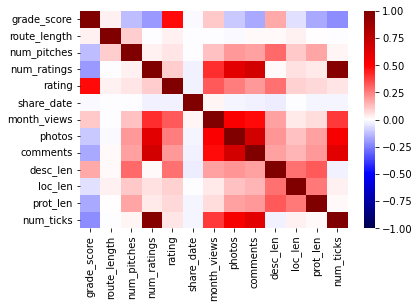

In [71]:
sns.heatmap(df.corr(), cmap='seismic', vmin=-1, vmax=1);

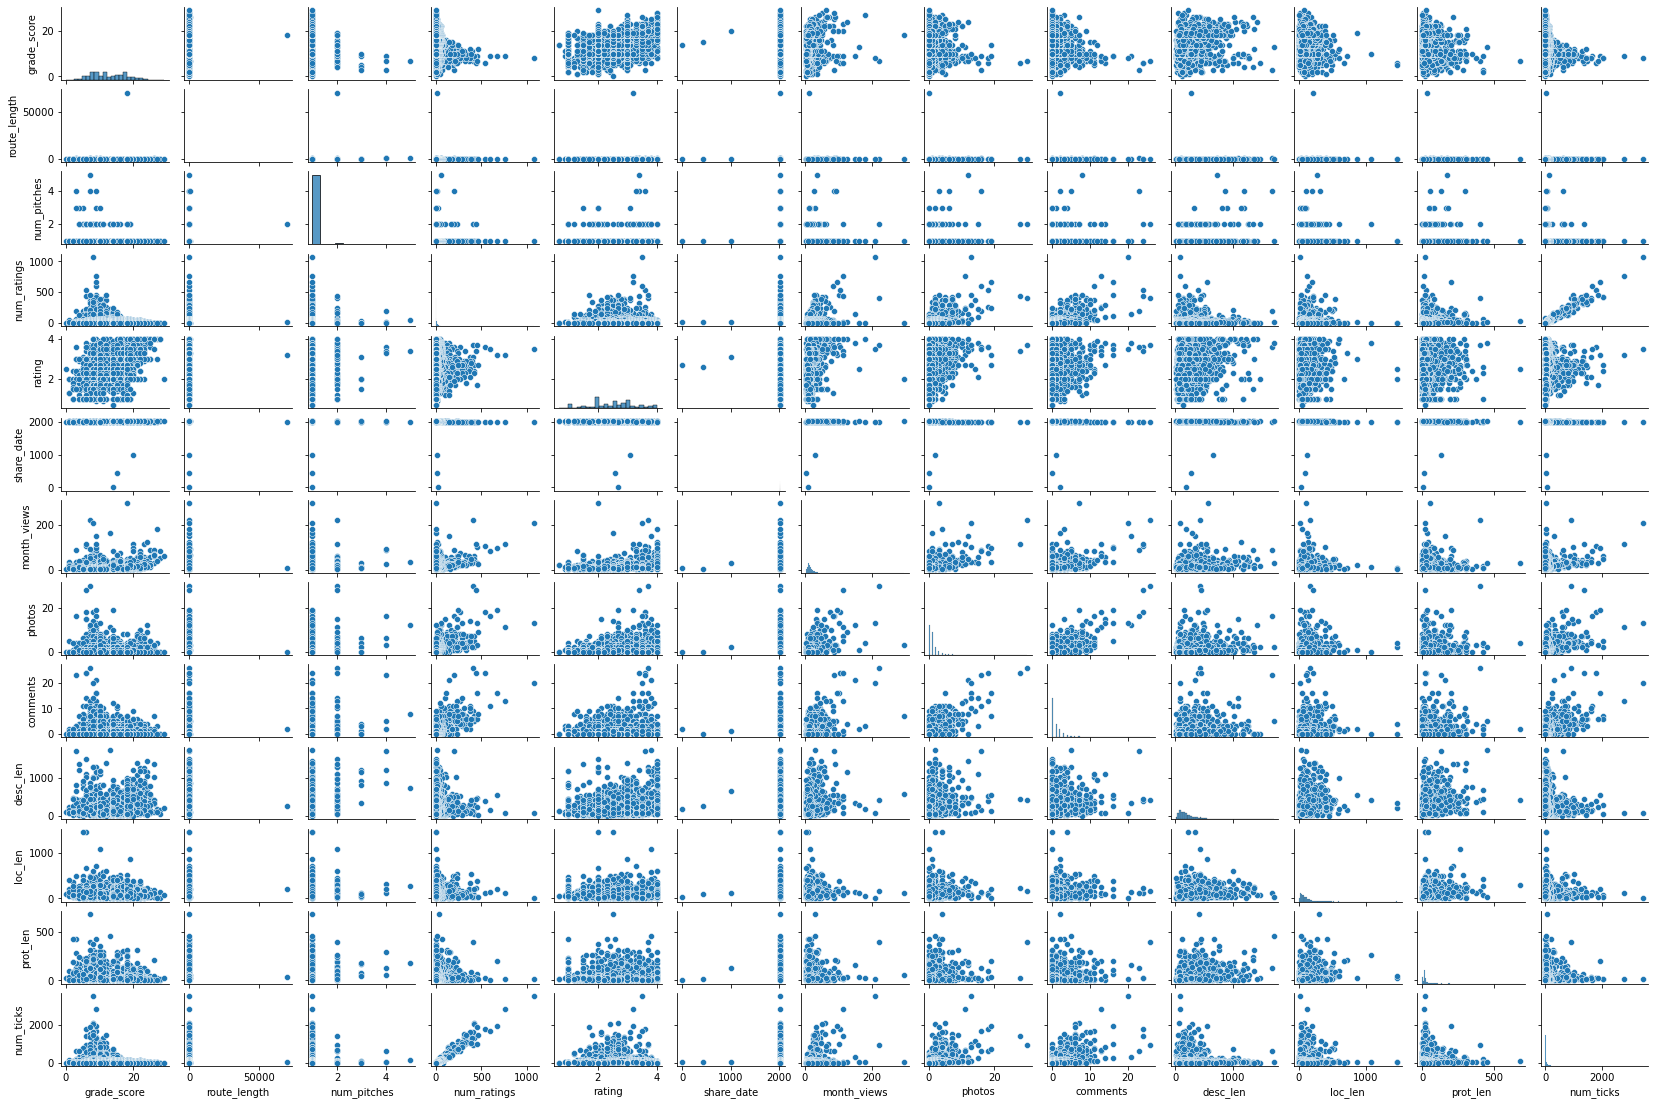

In [72]:
sns.pairplot(df, height=1.2, aspect=1.5);

In [80]:
df['route_length'].max()

70110.0

In [81]:
df = df[df['route_length'] != 70110.0]

Text(0.5, 1.0, 'Average Rating vs. Route Length')

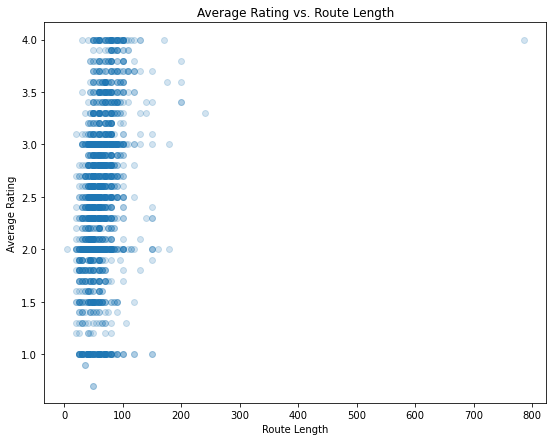

In [84]:
fig, ax = plt.subplots(figsize=(9, 7))

x = df['route_length']
y = df['rating']

ax.scatter(x, y, alpha=.2)
ax.set_xlabel('Route Length')
ax.set_ylabel('Average Rating')
ax.set_title('Average Rating vs. Route Length')

In [87]:
df['route_length'].max()

785.0

In [94]:
df = df[df['route_length']!=785.0]
df['route_length'].max()

240.0

Text(0.5, 1.0, 'Average Rating vs. Route Length')

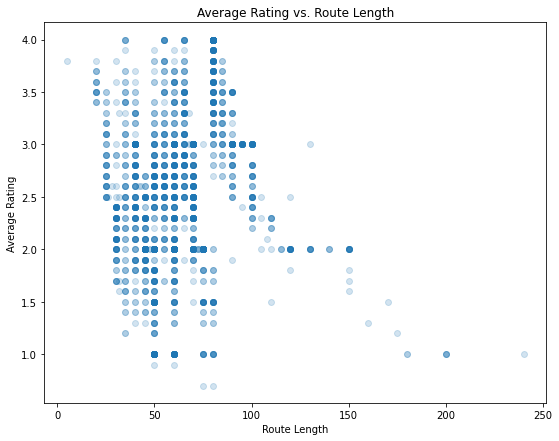

In [96]:
fig, ax = plt.subplots(figsize=(9, 7))

x = df['route_length']
y = df['rating']

ax.scatter(x, y, alpha=.2)
ax.set_xlabel('Route Length')
ax.set_ylabel('Average Rating')
ax.set_title('Average Rating vs. Route Length')

In [126]:
# Pickle dataframe 
df.to_pickle("mtn_project_df.pkl")